In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
!pip install scanpy
!pip install matplotlib==3.1.3
!pip install -U tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import scipy
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

Pancreas_adata = sc.read_text("/content/drive/My Drive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_LogX_CellCycleRegressedOut.txt", delimiter = '\t', first_column_names=None)
sc.pp.scale(Pancreas_adata)
Pancreas_adata

AnnData object with n_obs × n_vars = 2209 × 26179
    var: 'mean', 'std'

In [94]:
PancreasMetadata = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/Pancreas Data/Processed/PancreasMetadata.csv")
Pancreas_adata.obs['Cell Type'] = PancreasMetadata['Cell type'].values
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

In [95]:
PancreasCellID = []
for item in PancreasMetadata['Cell ID'].values:
  PancreasCellID.append(item)
Pancreas_adata.obs_names = PancreasCellID
Pancreas_adata.obs_names

Index(['HP1502401_H13', 'HP1502401_J14', 'HP1502401_B14', 'HP1502401_A14',
       'HP1502401_C14', 'HP1502401_G14', 'HP1502401_E14', 'HP1502401_L14',
       'HP1502401_M14', 'HP1502401_K14',
       ...
       'HP1526901T2D_M7', 'HP1526901T2D_N16', 'HP1526901T2D_C8',
       'HP1526901T2D_H2', 'HP1526901T2D_I16', 'HP1526901T2D_F7',
       'HP1525301T2D_K3', 'HP1525301T2D_J10', 'HP1526901T2D_N8',
       'HP1526901T2D_A8'],
      dtype='object', length=2209)

In [96]:
PancreasGenes = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_Genelist.txt",header=None)
PancreasGenelist = []
for item in PancreasGenes.values.tolist():
  PancreasGenelist.append(item[0])
Pancreas_adata.var_names = PancreasGenelist
Pancreas_adata.var_names

Index(['SGIP1', 'AZIN2', 'CLIC4', 'AGBL4', 'NECAP2', 'SLC45A1', 'TGFBR3',
       'DBT', 'RFWD2', 'C1orf21',
       ...
       'KIR3DS1', 'KIR2DL5B', 'KIR2DS2', 'KIR2DS1', 'KIR2DL2', 'KIR2DL4',
       'KIR2DS3', 'KIR2DS2', 'BIVM-ERCC5', 'ERCC_30000:mix1_7500:mix2'],
      dtype='object', length=26179)

In [97]:
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

In [98]:
# Pancreas_adata.write(filename="/content/drive/My Drive/ML4FG 2022/Data/Pancreas Data/Processed/Pancreas_CellCycleRegressedOut_AnnData.h5ad")

In [99]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [122]:
class VariationalAutoencoder(Model):
    def __init__(self, num_cell_types, num_genes, reg_penalties):
        super(VariationalAutoencoder, self).__init__()  
        self.reg_penalties = reg_penalties
        self.mean_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer),
        ])
        self.var_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear', 
                      kernel_regularizer=self.decoder_marker_gene_regularizer)
        ])

    def reparameterization(self, mean, var):
        epsilon = tf.random.normal(shape = [mean.shape[1]])             
        z = mean + (var*epsilon)                       
        return z
        
    def call(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        z = self.reparameterization(mean, tf.exp(0.5 * log_var))
        p = tf.keras.activations.softmax(z)
        decoded = self.decoder(p)
        return decoded

    def embed(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        var = tf.exp(0.5 * log_var)
        return tf.keras.activations.softmax(mean), mean, var

    def encoder_marker_gene_regularizer(self, w):
        return tf.reduce_sum(self.reg_penalties * tf.square(w))

    def decoder_marker_gene_regularizer(self, w):
        return tf.reduce_sum(self.reg_penalties.T * tf.square(w))

In [101]:
class Autoencoder(Model):
    def __init__(self, num_cell_types, num_genes, reg_penalties):
        super(Autoencoder, self).__init__()  
        self.reg_penalties = reg_penalties
        self.encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='softmax', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear', 
                      kernel_regularizer=self.decoder_marker_gene_regularizer)
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def embed(self, x):
      encoded = self.encoder(x)
      return encoded

    def encoder_marker_gene_regularizer(self, w):
      return tf.reduce_sum(self.reg_penalties * tf.square(w))

    def decoder_marker_gene_regularizer(self, w):
      return tf.reduce_sum(self.reg_penalties.T * tf.square(w))

In [124]:
# Creating regularization mask 

RegLevel = 0

marker_genes = Pancreas_adata.var_names
cell_types = Pancreas_adata.obs['Cell Type'].unique()

marker_gene_cell_type_reg_penalties = np.ones((len(marker_genes), len(cell_types))) * RegLevel
marker_gene_cell_type_reg_penalties.shape

(26179, 14)

In [125]:
NumPancreasCellTypes = len(Pancreas_adata.obs['Cell Type'].unique())
num_genes = Pancreas_adata.shape[1]
autoencoder = VariationalAutoencoder(NumPancreasCellTypes, num_genes, 
                                    marker_gene_cell_type_reg_penalties)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                    loss=losses.MeanSquaredError())
history = autoencoder.fit(Pancreas_adata.X, Pancreas_adata.X,
                          epochs=25,
                          shuffle=True,
                          validation_data=(Pancreas_adata.X, Pancreas_adata.X))

Epoch 1/25
70/70 [==============================] - 5s 66ms/step - loss: 0.8715 - val_loss: 0.8715
Epoch 2/25
70/70 [==============================] - 6s 80ms/step - loss: 0.8714 - val_loss: 0.8714
Epoch 3/25
70/70 [==============================] - 3s 41ms/step - loss: 0.8714 - val_loss: 0.8713
Epoch 4/25
70/70 [==============================] - 3s 37ms/step - loss: 0.8712 - val_loss: 0.8711
Epoch 5/25
70/70 [==============================] - 3s 41ms/step - loss: 0.8711 - val_loss: 0.8710
Epoch 6/25
70/70 [==============================] - 3s 49ms/step - loss: 0.8709 - val_loss: 0.8708
Epoch 7/25
70/70 [==============================] - 3s 37ms/step - loss: 0.8707 - val_loss: 0.8706
Epoch 8/25
70/70 [==============================] - 3s 38ms/step - loss: 0.8705 - val_loss: 0.8704
Epoch 9/25
70/70 [==============================] - 3s 38ms/step - loss: 0.8703 - val_loss: 0.8702
Epoch 10/25
70/70 [==============================] - 3s 37ms/step - loss: 0.8701 - val_loss: 0.8701
Epoch 11/

Text(0.5, 0, 'Epochs')

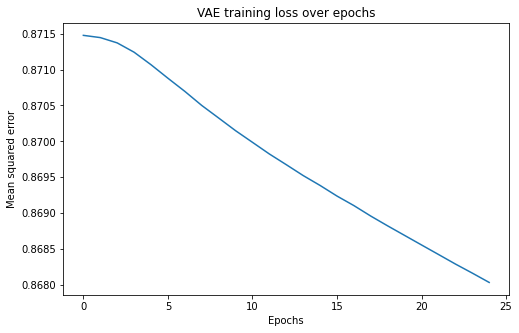

In [126]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('VAE training loss over epochs')
plt.ylabel('Mean squared error')
plt.xlabel('Epochs')

In [105]:
def Compute_tTest(mean1,var1,mean2,var2,n):
  tScore = (mean1-mean2) / math.sqrt((var1+var2)/n)
  DegFreedom = ((((var1**2)+(var2**2))/n)**2) / ((((var1**2)+(var2**2))/(n**2))/(n-1))
  return scipy.stats.t.sf(abs(tScore), df=DegFreedom)

In [131]:
latent_embedding, mean, var = autoencoder.embed(Pancreas_adata.X)

cell_type_labels  = []
for item in latent_embedding:
  cell_type_labels.append(str(np.where(item == max(item))[0][0]))

# compute pValue of each assignment and assign 'unknown' labels according p-value threshold
# NumPancreasCells = Pancreas_adata.shape[0]
# Pancreas_Assignment_PValues = []
# pVal_Threshold = 10

# for cell in range(NumPancreasCells):
#     MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
#     pVal = []
#     for LatentNode in range(NumPancreasCellTypes):
#       if LatentNode != MaxIndex:
#         pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
#                                    mean[cell,LatentNode],var[cell,LatentNode],
#                                    num_genes))
#     Pancreas_Assignment_PValues.append(pVal[np.argmax(pVal)])
#     if pVal[np.argmax(pVal)] > pVal_Threshold:
#       print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
#       cell_type_labels[cell] = 'Unknown'

# Pancreas_Assignment_PValues = np.array(Pancreas_Assignment_PValues).ravel()
# Pancreas_adata.obs['Pancreas pVal'] = Pancreas_Assignment_PValues

Pancreas_adata.obs['VAE Predicted Cell Type'] = cell_type_labels

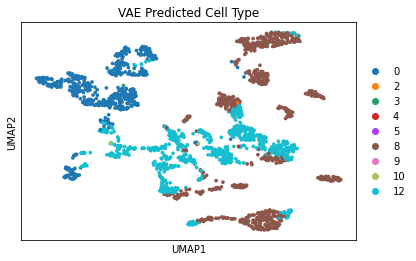

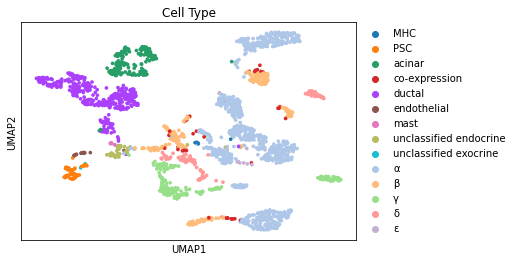

In [132]:
sc.tl.pca(Pancreas_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(Pancreas_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(Pancreas_adata)

sc.pl.umap(Pancreas_adata, color=['VAE Predicted Cell Type'])
sc.pl.umap(Pancreas_adata, color=['Cell Type'])

In [108]:
NumPancreasCellTypes = len(Pancreas_adata.obs['Cell Type'].unique())
num_genes = Pancreas_adata.shape[1]
autoencoder = Autoencoder(NumPancreasCellTypes, num_genes, 
                          marker_gene_cell_type_reg_penalties)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                    loss=losses.MeanSquaredError())
history = autoencoder.fit(Pancreas_adata.X, Pancreas_adata.X,
                          epochs=25,
                          shuffle=True,
                          validation_data=(Pancreas_adata.X, Pancreas_adata.X))

Epoch 1/25
70/70 [==============================] - 4s 53ms/step - loss: 210.1584 - val_loss: 195.4160
Epoch 2/25
70/70 [==============================] - 3s 43ms/step - loss: 182.6544 - val_loss: 169.7462
Epoch 3/25
70/70 [==============================] - 3s 36ms/step - loss: 158.5650 - val_loss: 147.2498
Epoch 4/25
70/70 [==============================] - 5s 71ms/step - loss: 137.4436 - val_loss: 127.5190
Epoch 5/25
70/70 [==============================] - 3s 39ms/step - loss: 118.9188 - val_loss: 110.2163
Epoch 6/25
70/70 [==============================] - 3s 37ms/step - loss: 102.6788 - val_loss: 95.0542
Epoch 7/25
70/70 [==============================] - 3s 37ms/step - loss: 88.4555 - val_loss: 81.7838
Epoch 8/25
70/70 [==============================] - 2s 35ms/step - loss: 76.0159 - val_loss: 70.1875
Epoch 9/25
70/70 [==============================] - 2s 35ms/step - loss: 65.1550 - val_loss: 60.0732
Epoch 10/25
70/70 [==============================] - 2s 35ms/step - loss: 55.691

In [109]:
latent_embedding = autoencoder.embed(Pancreas_adata.X)

cell_type_labels  = []
for item in latent_embedding:
  cell_type_labels.append(str(np.where(item == max(item))[0][0]))

# compute pValue of each assignment and assign 'unknown' labels according p-value threshold
# NumPancreasCells = Pancreas_adata.shape[0]
# Pancreas_Assignment_PValues = []
# pVal_Threshold = 10

# for cell in range(NumPancreasCells):
#     MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
#     pVal = []
#     for LatentNode in range(NumPancreasCellTypes):
#       if LatentNode != MaxIndex:
#         pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
#                                    mean[cell,LatentNode],var[cell,LatentNode],
#                                    num_genes))
#     Pancreas_Assignment_PValues.append(pVal[np.argmax(pVal)])
#     if pVal[np.argmax(pVal)] > pVal_Threshold:
#       print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
#       cell_type_labels[cell] = 'Unknown'

# Pancreas_Assignment_PValues = np.array(Pancreas_Assignment_PValues).ravel()
# Pancreas_adata.obs['Pancreas pVal'] = Pancreas_Assignment_PValues

Pancreas_adata.obs['AE Predicted Cell Type'] = cell_type_labels

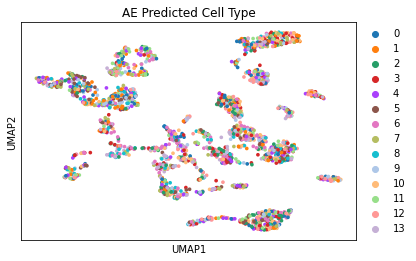

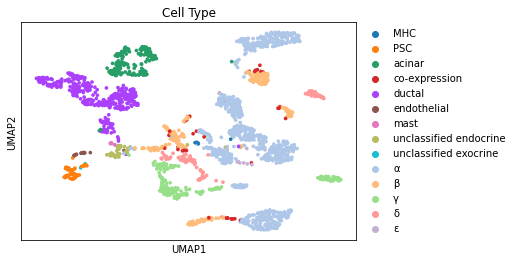

In [110]:
sc.tl.pca(Pancreas_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(Pancreas_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(Pancreas_adata)

sc.pl.umap(Pancreas_adata, color=['AE Predicted Cell Type'])
sc.pl.umap(Pancreas_adata, color=['Cell Type'])

In [111]:
# Read and process GBM data 

GBM_adata = sc.read_text("/content/drive/My Drive/ML for genomics project group /Data/GBM Data/Processed/GBM_LogX.txt", delimiter = '\t', first_column_names=None)
GBM_adata = GBM_adata.T 

GBMCellCycleScores = pd.read_table("/content/drive/My Drive/ML for genomics project group /Data/GBM Data/Processed/GbmCellCycleScores.txt", delimiter = '\t')
GBM_adata.obs['score_S'] = GBMCellCycleScores['score_S'].values
GBM_adata.obs['score_G2M'] = GBMCellCycleScores['score_G2M'].values
sc.pp.regress_out(GBM_adata, ['score_S', 'score_G2M'])

# Scale (zero-center) data
sc.pp.scale(GBM_adata)

GBM_Metadata = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/GBM Data/Processed/metadata2.csv")
GBM_adata.obs['Cell Type'] = GBM_Metadata['cell_assignment'].values

GBMGenes = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/GBM Data/Processed/features2.tsv",header=None)
GBMGenelist = []
for item in GBMGenes.values.tolist():
  GBMGenelist.append(item[0])
GBM_adata.var_names = GBMGenelist
GBM_adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1',
       'A4GALT', 'A4GNT', 'AA06',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=23686)

In [112]:
# Creating regularization mask 

marker_genes = GBM_adata.var_names
cell_types = GBM_adata.obs['Cell Type'].unique()

marker_gene_cell_type_reg_penalties = np.ones((len(marker_genes), len(cell_types))) * RegLevel
marker_gene_cell_type_reg_penalties.shape

(23686, 4)

In [113]:
NumGBMCellTypes = len(GBM_adata.obs['Cell Type'].unique())
num_genes = GBM_adata.shape[1]
autoencoder = VariationalAutoencoder(NumGBMCellTypes, num_genes, 
                                    marker_gene_cell_type_reg_penalties)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                    loss=losses.MeanSquaredError())
history = autoencoder.fit(GBM_adata.X, GBM_adata.X,
                          epochs=25,
                          shuffle=True,
                          validation_data=(GBM_adata.X, GBM_adata.X))

Epoch 1/25
248/248 [==============================] - 18s 68ms/step - loss: 77.4950 - val_loss: 60.5083
Epoch 2/25
248/248 [==============================] - 8s 33ms/step - loss: 47.9824 - val_loss: 37.0768
Epoch 3/25
248/248 [==============================] - 8s 33ms/step - loss: 29.0891 - val_loss: 22.1777
Epoch 4/25
248/248 [==============================] - 9s 35ms/step - loss: 17.1977 - val_loss: 12.9316
Epoch 5/25
248/248 [==============================] - 8s 30ms/step - loss: 9.9289 - val_loss: 7.3910
Epoch 6/25
248/248 [==============================] - 8s 34ms/step - loss: 5.6581 - val_loss: 4.2181
Epoch 7/25
248/248 [==============================] - 9s 38ms/step - loss: 3.2713 - val_loss: 2.5007
Epoch 8/25
248/248 [==============================] - 8s 32ms/step - loss: 2.0168 - val_loss: 1.6326
Epoch 9/25
248/248 [==============================] - 7s 30ms/step - loss: 1.4043 - val_loss: 1.2282
Epoch 10/25
248/248 [==============================] - 8s 31ms/step - loss: 1.1302

Text(0.5, 0, 'Epochs')

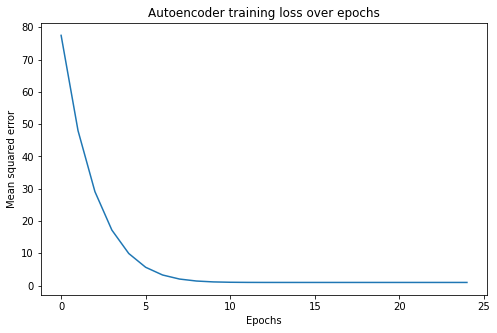

In [114]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('Autoencoder training loss over epochs')
plt.ylabel('Mean squared error')
plt.xlabel('Epochs')

In [115]:
latent_embedding, mean, var = autoencoder.embed(GBM_adata.X)

cell_type_labels  = []
for item in latent_embedding:
  cell_type_labels.append(str(np.where(item == max(item))[0][0]))

# compute pValue of each assignment and assign 'unknown' labels according p-value threshold
# NumGBMCells = GBM_adata.shape[0]
# GBM_Assignment_PValues = []
# pVal_Threshold = 10

# for cell in range(NumGBMCells):
#     MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
#     pVal = []
#     for LatentNode in range(NumGBMCellTypes):
#       if LatentNode != MaxIndex:
#         pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
#                                    mean[cell,LatentNode],var[cell,LatentNode],
#                                    num_genes))
#     GBM_Assignment_PValues.append(pVal[np.argmax(pVal)])
#     if pVal[np.argmax(pVal)] > pVal_Threshold:
#       print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
#       cell_type_labels[cell] = 'Unknown'

# GBM_Assignment_PValues = np.array(GBM_Assignment_PValues).ravel()
# GBM_adata.obs['GBM pVal'] = GBM_Assignment_PValues

GBM_adata.obs['VAE Predicted Cell Type'] = cell_type_labels

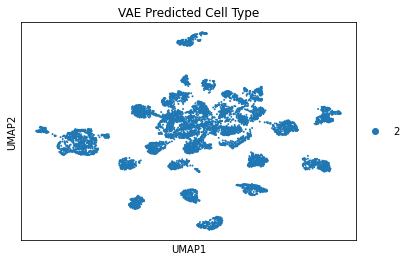

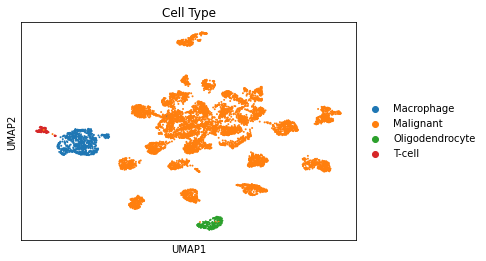

In [116]:
sc.tl.pca(GBM_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(GBM_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(GBM_adata)

sc.pl.umap(GBM_adata, color=['VAE Predicted Cell Type'])
sc.pl.umap(GBM_adata, color=['Cell Type'])

In [117]:
NumGBMCellTypes = len(GBM_adata.obs['Cell Type'].unique())
num_genes = GBM_adata.shape[1]
autoencoder = Autoencoder(NumGBMCellTypes, num_genes, 
                          marker_gene_cell_type_reg_penalties)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                    loss=losses.MeanSquaredError())
history = autoencoder.fit(GBM_adata.X, GBM_adata.X,
                          epochs=25,
                          shuffle=True,
                          validation_data=(GBM_adata.X, GBM_adata.X))

Epoch 1/25
248/248 [==============================] - 18s 71ms/step - loss: 51.9474 - val_loss: 40.6349
Epoch 2/25
248/248 [==============================] - 7s 29ms/step - loss: 32.2927 - val_loss: 25.0290
Epoch 3/25
248/248 [==============================] - 6s 26ms/step - loss: 19.7081 - val_loss: 15.1038
Epoch 4/25
248/248 [==============================] - 7s 28ms/step - loss: 11.7858 - val_loss: 8.9432
Epoch 5/25
248/248 [==============================] - 7s 29ms/step - loss: 6.9422 - val_loss: 5.2507
Epoch 6/25
248/248 [==============================] - 7s 29ms/step - loss: 4.0956 - val_loss: 3.1354
Epoch 7/25
248/248 [==============================] - 7s 27ms/step - loss: 2.5040 - val_loss: 1.9899
Epoch 8/25
248/248 [==============================] - 9s 35ms/step - loss: 1.6670 - val_loss: 1.4105
Epoch 9/25
248/248 [==============================] - 10s 39ms/step - loss: 1.2580 - val_loss: 1.1404
Epoch 10/25
248/248 [==============================] - 11s 44ms/step - loss: 1.074

Text(0.5, 0, 'Epochs')

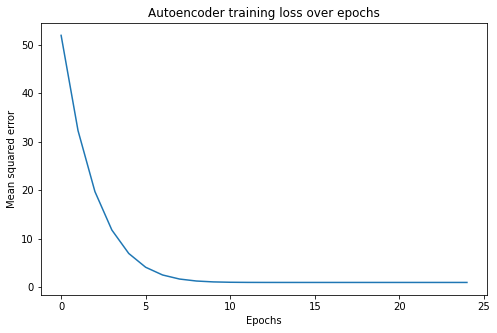

In [118]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('Autoencoder training loss over epochs')
plt.ylabel('Mean squared error')
plt.xlabel('Epochs')

In [119]:
latent_embedding = autoencoder.embed(GBM_adata.X)

cell_type_labels  = []
for item in latent_embedding:
  cell_type_labels.append(str(np.where(item == max(item))[0][0]))

# compute pValue of each assignment and assign 'unknown' labels according p-value threshold
# NumGBMCells = GBM_adata.shape[0]
# GBM_Assignment_PValues = []
# pVal_Threshold = 10

# for cell in range(NumGBMCells):
#     MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
#     pVal = []
#     for LatentNode in range(NumGBMCellTypes):
#       if LatentNode != MaxIndex:
#         pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
#                                    mean[cell,LatentNode],var[cell,LatentNode],
#                                    num_genes))
#     GBM_Assignment_PValues.append(pVal[np.argmax(pVal)])
#     if pVal[np.argmax(pVal)] > pVal_Threshold:
#       print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
#       cell_type_labels[cell] = 'Unknown'

# GBM_Assignment_PValues = np.array(GBM_Assignment_PValues).ravel()
# GBM_adata.obs['GBM pVal'] = GBM_Assignment_PValues

GBM_adata.obs['AE Predicted Cell Type'] = cell_type_labels

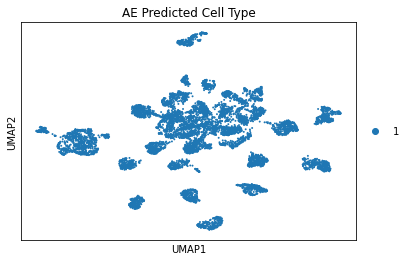

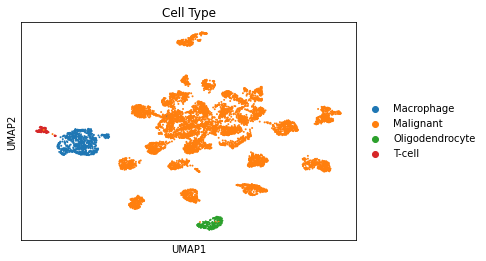

In [120]:
sc.tl.pca(GBM_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(GBM_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(GBM_adata)

sc.pl.umap(GBM_adata, color=['AE Predicted Cell Type'])
sc.pl.umap(GBM_adata, color=['Cell Type'])